In [ ]:
!pip install segyio
!pip install segysak
!pip install patchify
!pip install segmentation_models_3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 3.2 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.1 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 


In [ ]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

2.8.2
2.8.0
Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
Sat Aug 13 03:08:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import segyio
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_3D as sm
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from segysak.segy import segy_header_scan, segy_header_scrape, get_segy_texthead, segy_loader
from keras.metrics import MeanIoU
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap

Segmentation Models: using `tf.keras` framework.


/usr/local/lib/python3.7/dist-packages/segysak/segy/_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# Normalization
def normalization(data, clip_factor=2.5):
  clipFactor = clip_factor
  std0 = np.std(data)
  stdClip = std0 * clipFactor
  clippedCube = np.clip(data, -stdClip, +stdClip)
  return np.asarray(clippedCube / stdClip, dtype='single')

In [ ]:
train_seismic_path = '/content/drive/My Drive/UTP_dGB_Documents/data/train/seis'
train_fault_path = '/content/drive/My Drive/UTP_dGB_Documents/data/train/fault'

valid_seismic_path = '/content/drive/My Drive/UTP_dGB_Documents/data/validation/seis'
valid_fault_path = '/content/drive/My Drive/UTP_dGB_Documents/data/validation/fault'

## Run if we want to train new model

In [ ]:
train_seis_input = []
train_fault_output = []

index = [60, 120]
for i in os.listdir(train_seismic_path):
  for j in index:
    # iline
    train_seis_input.append(np.reshape(np.fromfile(train_seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[j, :, :])
    train_fault_output.append(np.reshape(np.fromfile(train_fault_path+'/'+i,dtype=np.single), (128, 128, 128))[j, :, :])
    # xline
    train_seis_input.append(np.reshape(np.fromfile(train_seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[:, j, :])
    train_fault_output.append(np.reshape(np.fromfile(train_fault_path+'/'+i,dtype=np.single), (128, 128, 128))[:, j, :])

In [ ]:
valid_seis_input = []
valid_fault_output = []

index = np.arange(0, 128, 64)
for i in os.listdir(valid_seismic_path):
  for j in index:
    # iline
    valid_seis_input.append(np.reshape(np.fromfile(valid_seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[j, :, :])
    valid_fault_output.append(np.reshape(np.fromfile(valid_fault_path+'/'+i,dtype=np.single), (128, 128, 128))[j, :, :])
    # xline
    valid_seis_input.append(np.reshape(np.fromfile(valid_seismic_path+'/'+i,dtype=np.single), (128, 128, 128))[:, j, :])
    valid_fault_output.append(np.reshape(np.fromfile(valid_fault_path+'/'+i,dtype=np.single), (128, 128, 128))[:, j, :])

In [ ]:
X_train = np.stack((train_seis_input,)*3, axis=-1)
X_test = np.stack((valid_seis_input,)*3, axis=-1)

train_mask = np.expand_dims(train_fault_output, axis=3)
y_train = tf.keras.utils.to_categorical(train_mask, num_classes=2)
test_mask = np.expand_dims(valid_fault_output, axis=3)
y_test = tf.keras.utils.to_categorical(test_mask, num_classes=2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 128, 128, 3)
(80, 128, 128, 3)
(800, 128, 128, 2)
(80, 128, 128, 2)


In [ ]:
X_train_norm = normalization(X_train)
X_test_norm = normalization(X_test)


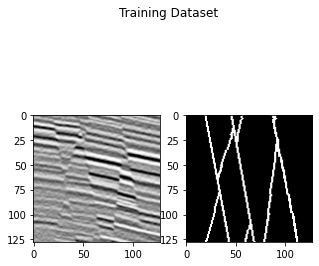

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(5,5))
ax[0].imshow(X_train_norm[1, :, :, 1].T, cmap='Greys')
ax[1].imshow(y_train[1, :, :, 1].T, cmap='Greys_r')
fig.suptitle('Training Dataset')
plt.show()


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

In [ ]:
batch_size = 8
image_size = 128

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    # encoder
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    # bridge
    bn = bottleneck(p4, f[4])
    
    # decoder
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(2, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model


In [ ]:
model_unet = UNet()
model_unet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
train_steps = len(X_train_norm)//batch_size
valid_steps = len(X_test_norm)//batch_size

In [ ]:
history_1 = model_unet.fit(X_train_norm, 
                    y_train,
                    batch_size=batch_size, 
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test_norm, y_test), ) # callbacks=EarlyStopping(monitor='val_acc', mode='max',patience=10))

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
plot_model(model_unet)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
    
    # select trainable layers layer 1:4 ==> Trainable = True, 5 = False
    for layer in vgg19.layers[:1]:
      layer.trainable = False
    
    for layer in vgg19.layers:
      print(layer, layer.trainable)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg19.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg19.get_layer("block3_conv4").output         ## (128 x 128)
    s4 = vgg19.get_layer("block4_conv4").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(2, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

In [ ]:
input_shape = (128,128, 3)
model_unet_vgg = build_vgg19_unet(input_shape)
model_unet_vgg.summary()

In [ ]:
model_unet_vgg.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
plot_model(model_unet_vgg)

In [ ]:
history_2 = model_unet_vgg.fit(X_train_norm, 
                    y_train,
                    batch_size=8, 
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test_norm, y_test), ) # callbacks=EarlyStopping(monitor='val_acc', mode='max',patience=10))

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']
epochs = range(1, len(loss_1) + 1)
plt.plot(epochs, loss_1, 'y-', label='UNet Training loss')
plt.plot(epochs, val_loss_1, 'r-', label='UNet Validation loss')
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
epochs = range(1, len(loss_2) + 1)
plt.plot(epochs, loss_2, 'y--', label='UNet VGG Training loss')
plt.plot(epochs, val_loss_2, 'r--', label='UNet VGG Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend()
plt.show()

acc_1 = history_1.history['acc']
val_acc_1 = history_1.history['val_acc']
acc_2 = history_2.history['acc']
val_acc_2 = history_2.history['val_acc']
epochs = range(1, len(acc_1) + 1)
plt.plot(epochs, acc_1, 'y-', label='UNet Training Acc')
plt.plot(epochs, val_acc_1, 'r-', label='UNet Validation Acc')
epochs = range(1, len(acc_2) + 1)
plt.plot(epochs, acc_2, 'y--', label='UNet VGG Training Acc')
plt.plot(epochs, val_acc_2, 'r--', label='UNet VGG Validation Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.ylim([0.8, 1])
plt.legend()
plt.show()

In [ ]:
#Predict on the test data
y_pred_1=model_unet.predict(X_test_norm)
y_pred_argmax_1=np.argmax(y_pred_1, axis=3)
y_pred_2=model_unet_vgg.predict(X_test_norm)
y_pred_argmax_2=np.argmax(y_pred_2, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
IOU_keras_1 = MeanIoU(num_classes=2)  
IOU_keras_1.update_state(y_test_argmax, y_pred_argmax_1)
print("Mean IoU Test UNet=", IOU_keras_1.result().numpy())
IOU_keras_2 = MeanIoU(num_classes=2)  
IOU_keras_2.update_state(y_test_argmax, y_pred_argmax_2)
print("Mean IoU Test UNet VGG=", IOU_keras_2.result().numpy())

In [ ]:
plt.figure(figsize=(15, 3))
ax1 = plt.subplot(141)
ax2 = plt.subplot(142)
ax3 = plt.subplot(143)
ax4 = plt.subplot(144)
randil = np.random.randint(0, len(X_test_norm), 1)[0]
ax1.imshow(X_test_norm[randil, : , :, 1].T)
ax2.imshow(y_test_argmax[randil, : , :].T)
ax3.imshow(y_pred_argmax_1[randil, : , :].T)
ax4.imshow(y_pred_argmax_2[randil, : , :].T)
ax1.set_title('Input')
ax2.set_title('Ground Truth')
ax3.set_title('UNet')
ax4.set_title('UNet VGG')
plt.tight_layout()
plt.show()

In [ ]:
model_unet.save('/content/drive/MyDrive/UTP_dGB_Documents/model/model_unet_1200data.h5')

In [ ]:
model_unet_vgg.save('/content/drive/MyDrive/UTP_dGB_Documents/model/model_unet_vgg_1200data.h5')

## Prediction

In [ ]:
model_unet = load_model('/content/drive/My Drive/UTP_dGB_Documents/model/model_unet_1200data.h5', compile=False)

In [ ]:
model_unet_vgg = load_model('/content/drive/My Drive/UTP_dGB_Documents/model/model_unet_vgg_1200data.h5', compile=False)

In [ ]:
# Prediction
seismic = np.reshape(np.fromfile("/content/drive/My Drive/UTP_dGB_Documents/data/prediction/f3d/gxl.dat",dtype=np.single),(512,384,128))
seismic.shape

(512, 384, 128)

In [ ]:
seisnorm = normalization(seismic)

In [ ]:
def append_patch(model, patches, predicted_patches, i, j): 
  single_patch = patches[i,j,:,:]
  single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
  single_patch_3ch_input = np.expand_dims(single_patch_3ch, axis=0)
  single_patch_prediction = model.predict(single_patch_3ch_input)
  single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=3)[0,:,:]
  return predicted_patches.append(single_patch_prediction_argmax)

In [ ]:
def prediction(seismic, model, mode='inline'):
  # Append 2D seismic into 3D seismic
  if mode=='inline':
    predicted = []
    for i in range(seismic.shape[0]):
      val_input = seismic[i, :, :]
      patches = patchify(val_input, (128, 128), step=128)
      predicted_patches = []
      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          append_patch(model, patches, predicted_patches, i, j)
      predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3]))
      reconstructed_seismic = unpatchify(predicted_patches_reshaped, val_input.shape)
      predicted.append(reconstructed_seismic)
    return np.array(predicted)
  elif mode=='crossline':
    predicted = []
    for i in range(seismic.shape[1]):
      val_input = seismic[:, i, :]
      patches = patchify(val_input, (128, 128), step=128)
      predicted_patches = []
      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          append_patch(model, patches, predicted_patches, i, j)
      predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3]))
      reconstructed_seismic = unpatchify(predicted_patches_reshaped, val_input.shape)
      predicted.append(reconstructed_seismic)
    return np.array(predicted)

In [ ]:
unet_predicted_il = prediction(seisnorm, model_unet, mode='inline')

In [ ]:
unet_predicted_xl = prediction(seisnorm, model_unet, mode='crossline')

In [ ]:
unet_vgg_predicted_il = prediction(seisnorm, model_unet_vgg, mode='inline')

In [ ]:
unet_vgg_predicted_xl = prediction(seisnorm, model_unet_vgg, mode='crossline')

In [ ]:
# def prediction(model):
#   il_range = np.arange(0, 640, 128)
#   pred_3d = []
#   for i in range(384):
#     pred_2d = []
#     for j in range(0, 4):
#       il_min = il_range[j]
#       il_max = il_range[j+1]
#       seis = seismic[il_min:il_max, i, :]
#       pred = np.stack((seis,)*3, axis=-1)
#       pred_2d.append(pred)
#     pred_3d.append(np.vstack(np.argmax(model.predict(np.array(pred_2d)), axis=3)))
#   return np.array(pred_3d).reshape(512, 384, 128)

In [ ]:
# unet_prediction = prediction(seisnorm, model_unet)

In [ ]:
# unet_vgg_prediction = prediction(seisnorm, model_unet_vgg)

In [ ]:
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,0,ncolors)
color_array[253:256] = [1, 0.0, 0., 1]
map_object = LinearSegmentedColormap.from_list(name='fault',colors=color_array)
plt.register_cmap(cmap=map_object)

In [ ]:
vm = np.percentile(seisnorm, 99)

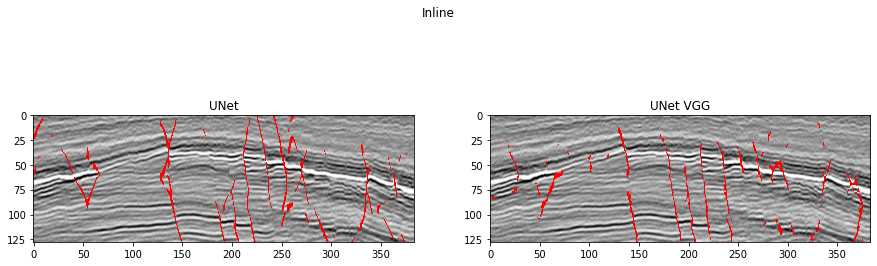

In [ ]:
il = 53
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(seisnorm[il,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[0].imshow(unet_predicted_il[il, :, :].T, cmap='fault')
ax[0].set_title('UNet')
ax[1].imshow(seisnorm[il,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[1].imshow(unet_vgg_predicted_il[il, :, :].T, cmap='fault')
ax[1].set_title('UNet VGG')
plt.suptitle('Inline')
plt.show()

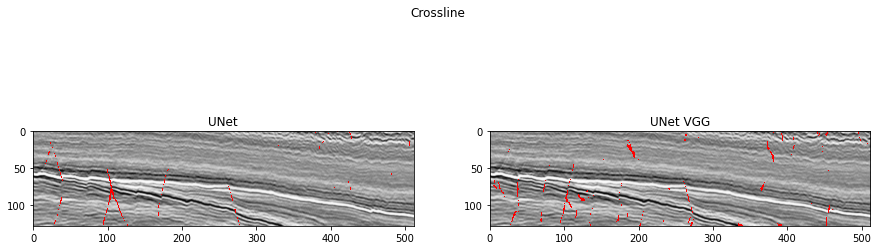

In [ ]:
xl = 24
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(seisnorm[:,xl,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[0].imshow(unet_predicted_xl[xl, :, :].T, cmap='fault')
ax[0].set_title('UNet')
ax[1].imshow(seisnorm[:,xl,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[1].imshow(unet_vgg_predicted_xl[xl, :, :].T, cmap='fault')
ax[1].set_title('UNet VGG')
plt.suptitle('Crossline')
plt.show()


In [ ]:
print(unet_predicted_il.shape)
print(unet_predicted_xl.shape)
print(unet_vgg_predicted_il.shape)
print(unet_vgg_predicted_xl.shape)
unet_predicted_xl_transposed = np.moveaxis(unet_predicted_xl, 1, 0)
print(unet_predicted_xl_transposed.shape)
unet_vgg_predicted_xl_transposed = np.moveaxis(unet_vgg_predicted_xl, 1, 0)
print(unet_vgg_predicted_xl_transposed.shape)

(512, 384, 128)
(384, 512, 128)
(512, 384, 128)
(384, 512, 128)
(512, 384, 128)
(512, 384, 128)


In [ ]:
combined_unet = unet_predicted_il + unet_predicted_xl_transposed
combined_unet[combined_unet > 0] = 1
combined_unet_vgg = unet_vgg_predicted_il + unet_vgg_predicted_xl_transposed
combined_unet_vgg[combined_unet_vgg > 0] = 1

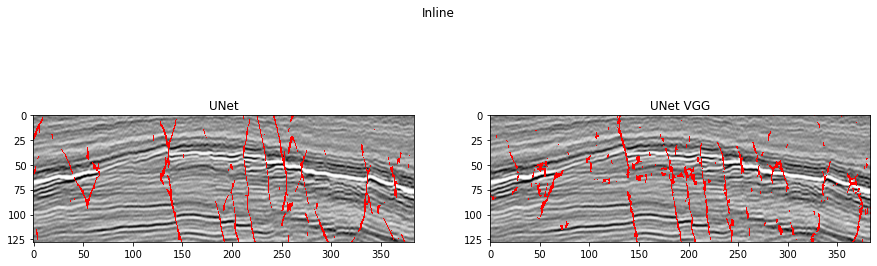

In [ ]:
il = 53
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(seisnorm[il,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[0].imshow(combined_unet[il, :, :].T, cmap='fault')
ax[0].set_title('UNet')
ax[1].imshow(seisnorm[il,:,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[1].imshow(combined_unet_vgg[il, :, :].T, cmap='fault')
ax[1].set_title('UNet VGG')
plt.suptitle('Inline')
plt.show()

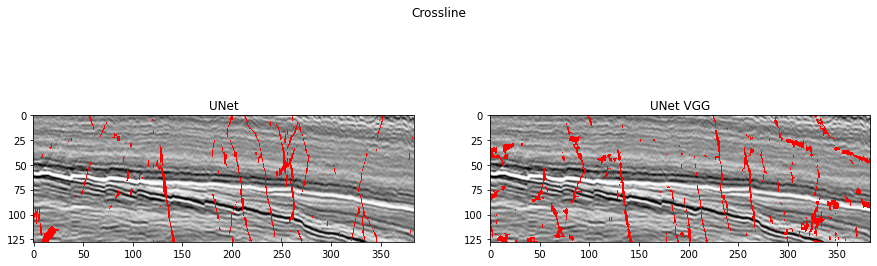

In [ ]:
xl = 24
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(seisnorm[:,xl,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[0].imshow(combined_unet[xl, :, :].T, cmap='fault')
ax[0].set_title('UNet')
ax[1].imshow(seisnorm[:,xl,:].T, cmap='Greys', vmin=-vm, vmax=vm, interpolation='bicubic')
ax[1].imshow(combined_unet_vgg[xl, :, :].T, cmap='fault')
ax[1].set_title('UNet VGG')
plt.suptitle('Crossline')
plt.show()
